# functions

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.callbacks import EarlyStopping
from scipy.interpolate import griddata


import warnings
warnings.filterwarnings('ignore')

In [52]:
def load_data():

    dataset = datasets.load_digits()
    X = dataset.data
    y = dataset.target

    return X, y

In [53]:
def standardize(X_train, X_val, X_test):

    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_val_std = sc.transform(X_val)
    X_test_std = sc.transform(X_test)

    return X_train_std, X_val_std, X_test_std

In [54]:
def get_train_test_split(X, y, test_size):


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    X_train, X_val, X_test = standardize(X_train, X_val, X_test)

    X_train = X_train.reshape(-1, 8, 8, 1)
    X_val = X_val.reshape(-1, 8, 8, 1)
    X_test = X_test.reshape(-1, 8, 8, 1)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [55]:
def build_cnn(n_hidden_layers, n_filters):

    input_shape = (8, 8, 1)
    num_classes = 10

    model = tf.keras.models.Sequential()
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Conv2D(n_filters, kernel_size = (2, 2), activation='relu', input_shape=input_shape))
        #model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    #model.summary()

    return model

In [56]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, n_epochs=100, batch_size=32, patience=10, print_summary=True):

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )


    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    history = model.fit(X_train,
                        y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0)


    test_loss, test_acc = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    
    if print_summary:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.legend()
        plt.show()
        print(confusion_matrix(y_test, y_pred_classes))
        print(classification_report(y_test, y_pred_classes))

    n_params = model.count_params()

    return history, test_acc, n_params

In [57]:
def plot_3d_mesh_results(results_df):

    train_size = results_df['train_size']
    n_params = results_df['n_params']
    test_accuracy = results_df['test_accuracy']

    grid_x, grid_y = np.meshgrid(
        np.linspace(train_size.min(), train_size.max(), 100),
        np.linspace(n_params.min(), n_params.max(), 100)
    )
    grid_z = griddata(
        (train_size, n_params), test_accuracy, (grid_x, grid_y), method='cubic'
    )

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)
    
    cbar = plt.colorbar(surface, ax=ax, pad=0.1)
    cbar.set_label('Test Accuracy', rotation=270, labelpad=15)

    ax.set_xlabel('Train Size')
    ax.set_ylabel('Number of Parameters (n_params)')
    ax.set_zlabel('Test Accuracy')
    ax.set_title('3D Mesh Grid of Results: Train Size, Parameters, and Test Accuracy')

    plt.show()

# main

In [58]:
X, y = load_data()

***Build and train a simple convolutional neural network model (of one or two convolutional layers) to classify the images in the digits data set. Evaluate its performance***

In [59]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, test_size=0.2)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9899 - loss: 0.0262  
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


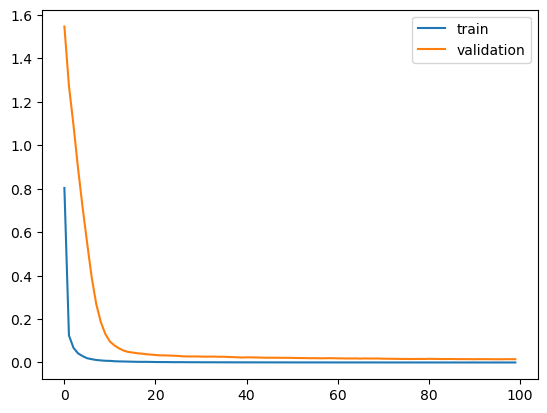

[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  1 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       1.00      1.00      1.00        46
           5       0.96      0.98      0.97        47
           6       0.97      0.97      0.97        35
           7       1.00      0.97      0.99        34
           8       0.97      1.00      0.98        30
           9       0.97      0.97      0.97        40

    accuracy                           0.99       360
   macro avg       

(<keras.src.callbacks.history.History at 0x7fd16709feb0>,
 0.9861111044883728,
 16074)

In [60]:
n_hidden_layers = 2
n_filters = 32

model = build_cnn(n_hidden_layers=n_hidden_layers, n_filters=n_filters)
train_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

***Investigate the performance of the convolutional neural network in terms of the size
of the training data and the design of the layers. Try to find a network with as few
parameters as possible, without sacrificing performance***

In [61]:
result_dataframe = pd.DataFrame(columns=['train_size','n_params','n_hidden_layers', 'n_filters', 'test_accuracy', ])

In [62]:
n_hidden_layers = np.arange(1, 6)
n_filters = np.arange(16, 65, 16)

test size = 50%

In [63]:
test_split = 0.5

X_train50, X_val50, X_test50, y_train50, y_val50, y_test50 = get_train_test_split(X, y, test_size=test_split)
train_size = X_train50.shape[0]

In [64]:
for n_hidden_layer in n_hidden_layers:
    for n_filter in n_filters:
        
        model = build_cnn(n_hidden_layer, n_filter)
        history, test_accuracy, n_params = train_model(model, X_train50, y_train50, X_val50, y_val50, X_test50, y_test50, print_summary=False)

        
        new_row = pd.DataFrame({
            'train_size': [train_size],
            'n_params': [n_params],
            'n_hidden_layers': [n_hidden_layer],
            'n_filters': [n_filter],
            'test_accuracy': [test_accuracy]
        })
        
        print('-'*150)
        print(new_row)
        print('-'*150)
        print()

        result_dataframe = pd.concat([result_dataframe, new_row], ignore_index=True)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9837 - loss: 0.0878 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
------------------------------------------------------------------------------------------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0         718      7994                1         16       0.973304
------------------------------------------------------------------------------------------------------------------------------------------------------

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9727 - loss: 0.1060 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
------------------------------------------------------------------------------------------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0         718     15978                1         32       0.965517
----------------------------------------------------

test size = 70%

In [65]:
test_split = 0.3
train_size = X_train.shape[0]

X_train30, X_val30, X_test30, y_train30, y_val30, y_test30 = get_train_test_split(X, y, test_size=test_split)
train_size = X_train30.shape[0]

In [66]:
for n_hidden_layer in n_hidden_layers:
    for n_filter in n_filters:
        
        model = build_cnn(n_hidden_layer, n_filter)
        history, test_accuracy, n_params = train_model(model, X_train30, y_train30, X_val30, y_val30, X_test30, y_test30, print_summary=False)

        
        new_row = pd.DataFrame({
            'train_size': [train_size],
            'n_params': [n_params],
            'n_hidden_layers': [n_hidden_layer],
            'n_filters': [n_filter],
            'test_accuracy': [test_accuracy]
        })
        
        print('-'*150)
        print(new_row)
        print('-'*150)
        print()

        result_dataframe = pd.concat([result_dataframe, new_row], ignore_index=True)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9892 - loss: 0.0468 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
------------------------------------------------------------------------------------------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0        1005      7994                1         16       0.985185
------------------------------------------------------------------------------------------------------------------------------------------------------

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0434 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
------------------------------------------------------------------------------------------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0        1005     15978                1         32       0.985185
----------------------------------------------------

test size = 90%

In [67]:
test_split = 0.1
train_size = X_train.shape[0]

X_train10, X_val10, X_test10, y_train10, y_val10, y_test10 = get_train_test_split(X, y, test_size=test_split)
train_size = X_train10.shape[0]

In [68]:
for n_hidden_layer in n_hidden_layers:
    for n_filter in n_filters:
        
        model = build_cnn(n_hidden_layer, n_filter)
        history, test_accuracy, n_params = train_model(model, X_train10, y_train10, X_val10, y_val10, X_test10, y_test10, print_summary=False)

        
        new_row = pd.DataFrame({
            'train_size': [train_size],
            'n_params': [n_params],
            'n_hidden_layers': [n_hidden_layer],
            'n_filters': [n_filter],
            'test_accuracy': [test_accuracy]
        })

        print('-'*150)
        print(new_row)
        print('-'*150)
        print()

        result_dataframe = pd.concat([result_dataframe, new_row], ignore_index=True)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9808 - loss: 0.0392 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
------------------------------------------------------------------------------------------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0        1293      7994                1         16       0.977778
------------------------------------------------------------------------------------------------------------------------------------------------------

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0237 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
------------------------------------------------------------------------------------------------------------------------------------------------------
   train_size  n_params  n_hidden_layers  n_filters  test_accuracy
0        1293     15978                1         32       0.983333
----------------------------------------------------------

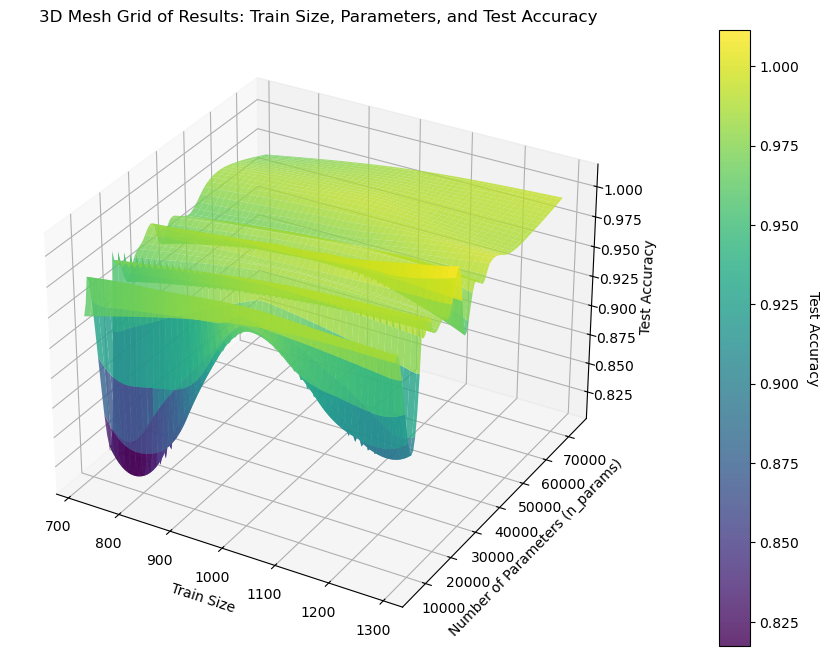

In [69]:
plot_3d_mesh_results(result_dataframe)

In [71]:
result_dataframe.to_csv('results.csv', index=False)